In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, lower, regexp_replace, col, sum as _sum
from pyspark.sql.functions import lower, regexp_replace
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("ZipfLaw").getOrCreate()

df = spark.read.text("bible.txt")

24/07/18 14:14:40 WARN Utils: Your hostname, linux resolves to a loopback address: 127.0.1.1; using 192.168.10.105 instead (on interface wlp4s0)
24/07/18 14:14:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/18 14:14:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#tokenization
words_df  = df.select(explode(split(df.value, "\s")).alias("word"))

In [4]:
#lowercase and remove punctuation
words_clean = words_df.select(regexp_replace(lower(words_df.word), "[^a-z]", "").alias("word"))

In [5]:
word_count_df = words_clean.groupBy("word").count().orderBy("count", ascending=False)

In [6]:
window_spec = Window.orderBy(word_count_df["count"].desc())
ranked_df = word_count_df.withColumn("rank", row_number().over(window_spec))

In [7]:
pandas_df = ranked_df.toPandas()

24/07/18 14:14:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 14:14:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 14:14:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 14:14:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 14:14:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 14:14:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 1

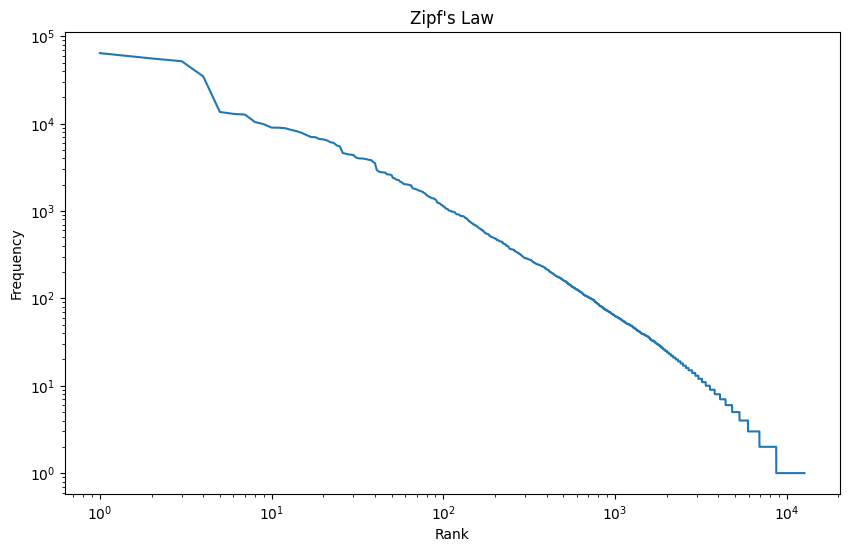

In [8]:
plt.figure(figsize=(10, 6))
plt.loglog(pandas_df["rank"], pandas_df["count"])
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf's Law")
plt.show()

In [9]:
# Calculate word frequencies
word_counts_df = words_clean.groupBy("word").count().filter(col("word") != "")
total_word_count = word_counts_df.agg(_sum("count").alias("total")).collect()[0]["total"]

In [10]:
from pyspark.sql.functions import round

word_percentage_df = word_counts_df.withColumn("percentage", round(col("count") / total_word_count * 100, 2))

In [11]:
# Show the word, count, and percentage
word_percentage_df.orderBy("count", ascending=False).show(truncate=False)


+-----+-----+----------+
|word |count|percentage|
+-----+-----+----------+
|the  |64020|8.1       |
|and  |51696|6.54      |
|of   |34668|4.39      |
|to   |13580|1.72      |
|that |12912|1.63      |
|in   |12667|1.6       |
|he   |10419|1.32      |
|shall|9838 |1.25      |
|unto |8997 |1.14      |
|for  |8971 |1.14      |
|i    |8854 |1.12      |
|his  |8473 |1.07      |
|a    |8177 |1.04      |
|lord |7830 |0.99      |
|they |7376 |0.93      |
|be   |7013 |0.89      |
|is   |6989 |0.88      |
|him  |6659 |0.84      |
|not  |6596 |0.83      |
|them |6430 |0.81      |
+-----+-----+----------+
only showing top 20 rows

